In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
#import graphviz
import pyarrow
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

sns.set_style("white")
plt.rcParams['figure.dpi'] = 300

In [71]:
eng_stats_df = pd.read_feather("Award_Batting_HOF_FE.feather")

In [72]:
# X = eng_stats_df[['Batting_df_G_avg', 'Batting_df_G_total', 'Batting_df_AB_avg', 'Batting_df_AB_total', 'Batting_df_R_avg', 'Batting_df_R_total', 'Batting_df_H_avg', 'Batting_df_H_total', 'Batting_df_2B_avg', 'Batting_df_2B_total', 'Batting_df_3B_avg', 'Batting_df_3B_total', 'Batting_df_HR_avg', 'Batting_df_HR_total', 'Batting_df_RBI_avg', 'Batting_df_RBI_total', 'Batting_df_SB_avg', 'Batting_df_SB_total', 'Batting_df_CS_avg', 'Batting_df_CS_total', 'Batting_df_BB_avg', 'Batting_df_BB_total', 'Batting_df_SO_avg', 'Batting_df_SO_total', 'Batting_df_IBB_avg', 'Batting_df_IBB_total', 'Batting_df_HBP_avg', 'Batting_df_HBP_total', 'Batting_df_SH_avg', 'Batting_df_SH_total', 'Batting_df_SF_avg', 'Batting_df_SF_total', 'Batting_df_GIDP_avg', 'Batting_df_GIDP_total', 'BattingPost_df_G_avg', 'BattingPost_df_G_total', 'BattingPost_df_AB_avg', 'BattingPost_df_AB_total', 'BattingPost_df_R_avg', 'BattingPost_df_R_total', 'BattingPost_df_H_avg', 'BattingPost_df_H_total', 'BattingPost_df_2B_avg', 'BattingPost_df_2B_total', 'BattingPost_df_3B_avg', 'BattingPost_df_3B_total', 'BattingPost_df_HR_avg', 'BattingPost_df_HR_total', 'BattingPost_df_RBI_avg', 'BattingPost_df_RBI_total', 'BattingPost_df_SB_avg', 'BattingPost_df_SB_total', 'BattingPost_df_CS_avg', 'BattingPost_df_CS_total', 'BattingPost_df_BB_avg', 'BattingPost_df_BB_total', 'BattingPost_df_SO_avg', 'BattingPost_df_SO_total', 'BattingPost_df_IBB_avg', 'BattingPost_df_IBB_total', 'BattingPost_df_HBP_avg', 'BattingPost_df_HBP_total', 'BattingPost_df_SH_avg', 'BattingPost_df_SH_total', 'BattingPost_df_SF_avg', 'BattingPost_df_SF_total', 'BattingPost_df_GIDP_avg', 'BattingPost_df_GIDP_total']]

X = eng_stats_df[[
    'years_played', 'total_games', 'total_at_bats', 'total_runs', 'total_hits',
    'total_walks', 'total_doubles', 'total_triples', 'total_home_runs',
    'total_RBI', 'total_SB', 'total_CS', 'total_BB', 'total_SO', 'total_IBB',
    'total_HBP', 'total_SH', 'total_SF', 'total_GIDP', 'max_HR', 'max_hits',
    'max_SB', 'total_singles', 'batting_avg', 'OBP', 'SLG', 'OPS'
]].fillna(0)  # Replace NaNs with 0

y = eng_stats_df['HOF_status']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rfr_model_1 = RandomForestRegressor()
rfr_model_1.fit(X_train_scaled, y_train)

y_pred = rfr_model_1.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%')

Mean Squared Error: 0.011963243243243242
R-squared: 0.5872903971956985
Root Mean Squared Error (RMSE): 0.10937661195723353
Mean Absolute Percentage Error (MAPE): 4556344487871233.00%


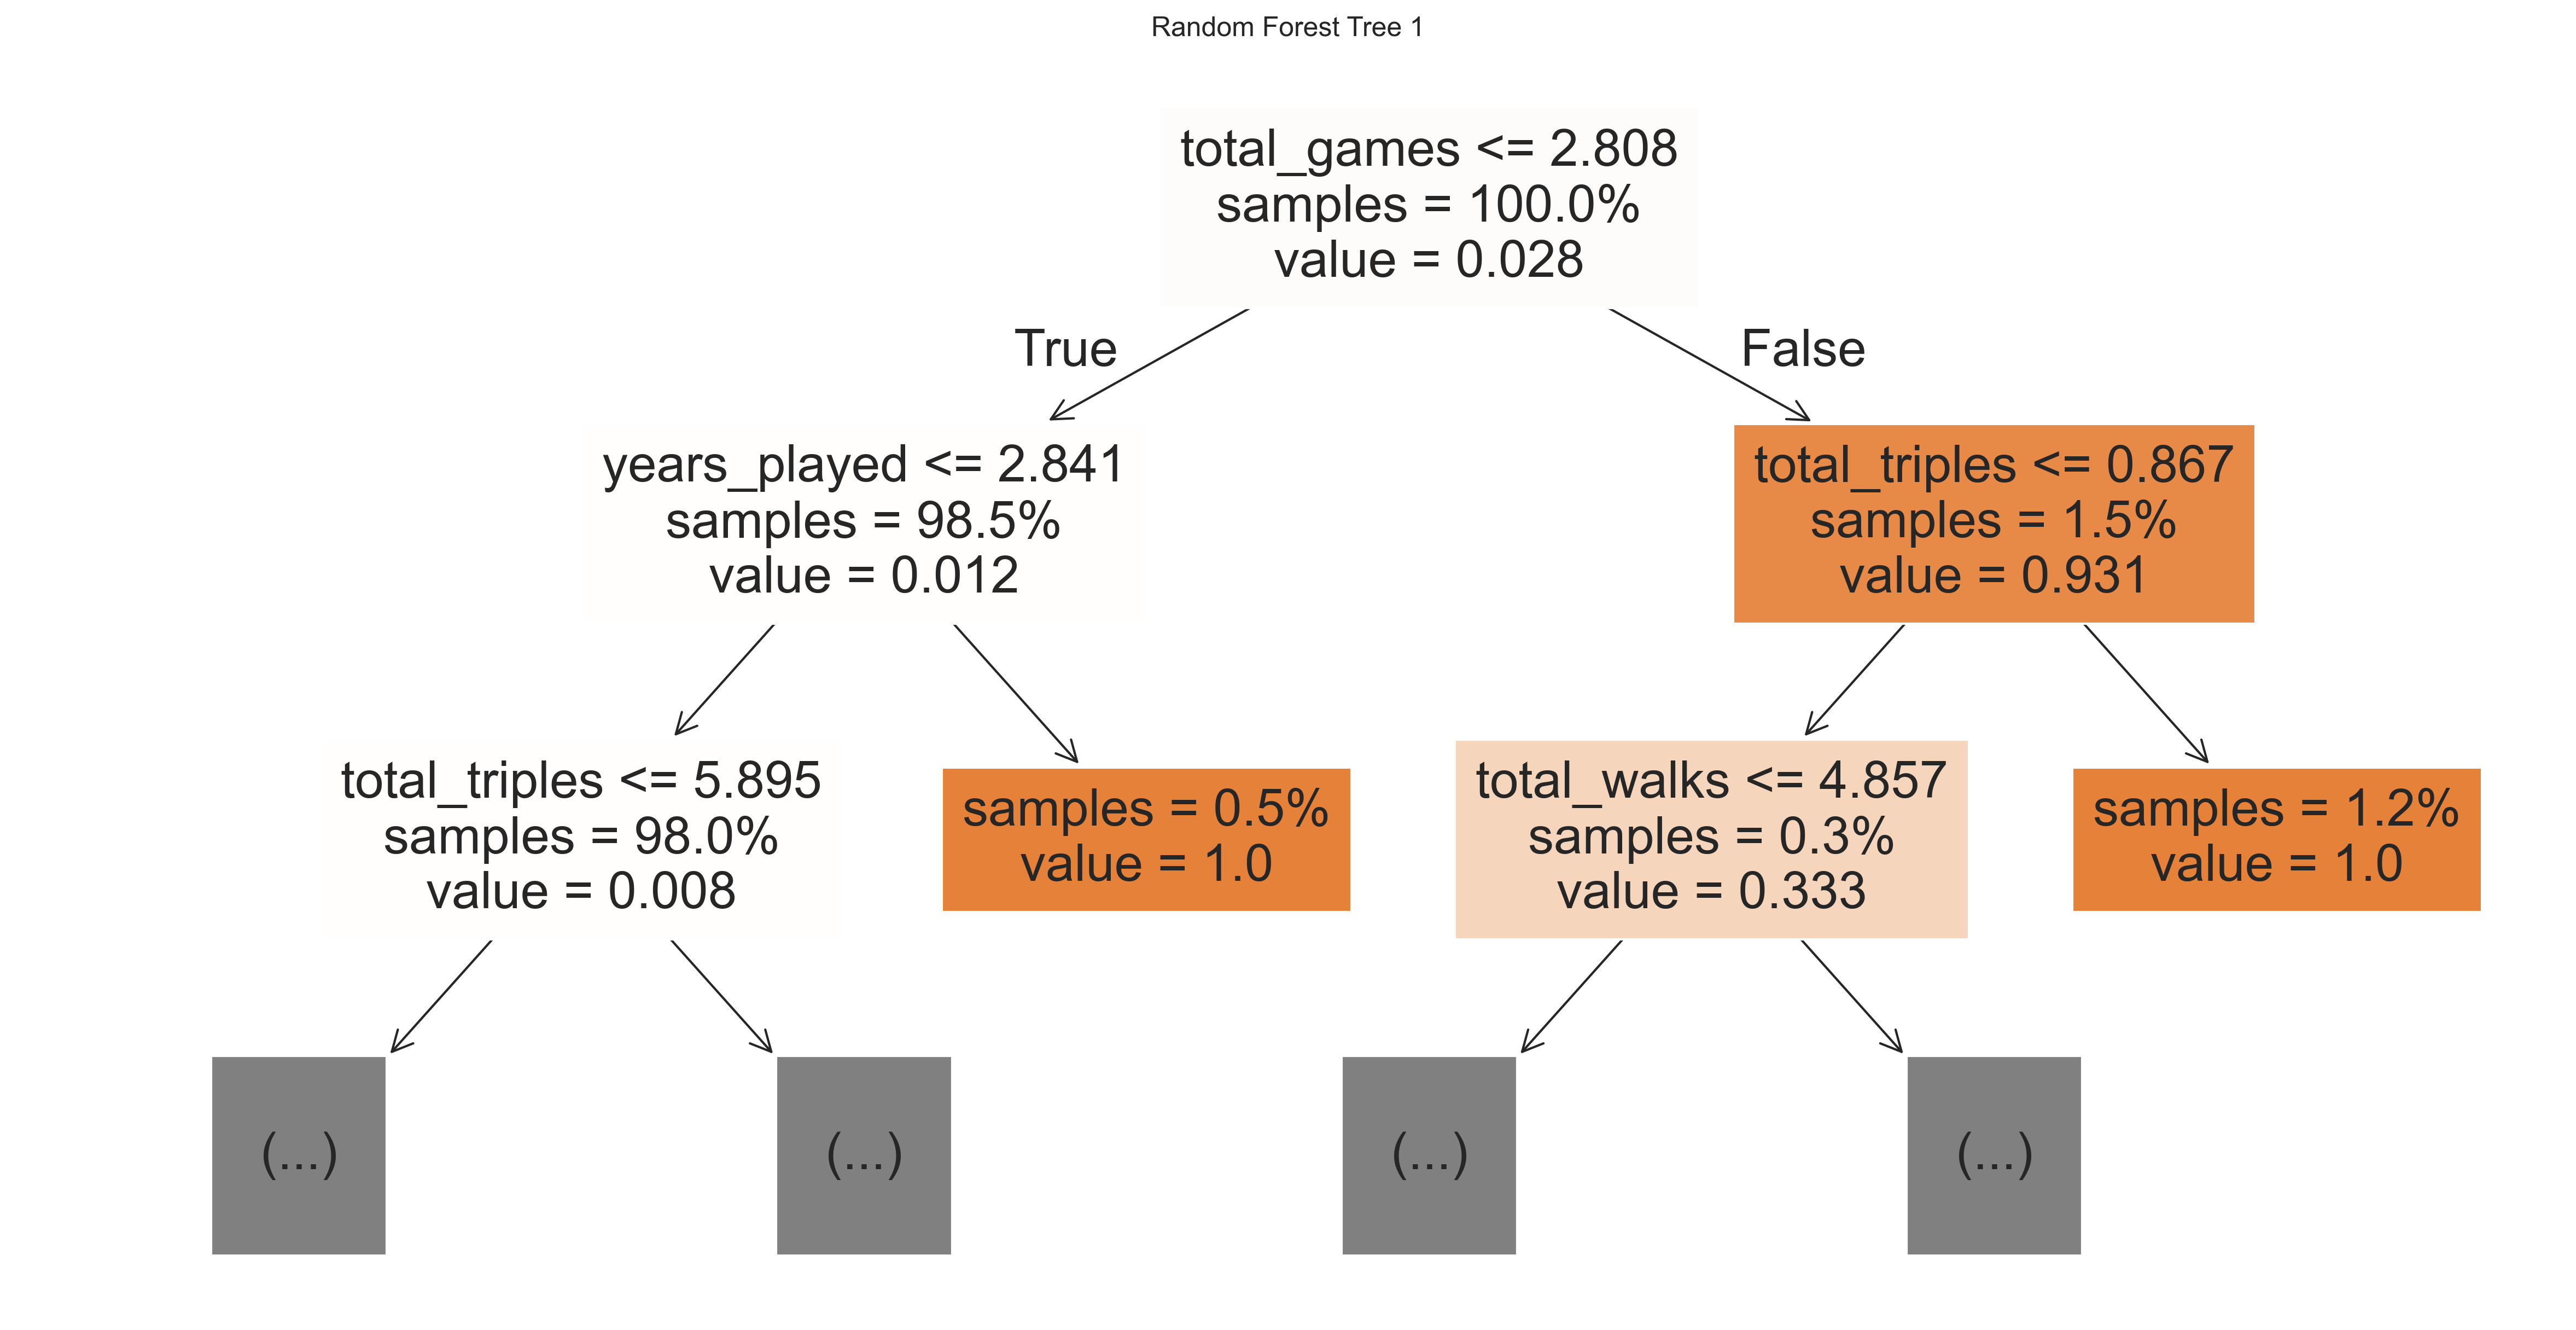

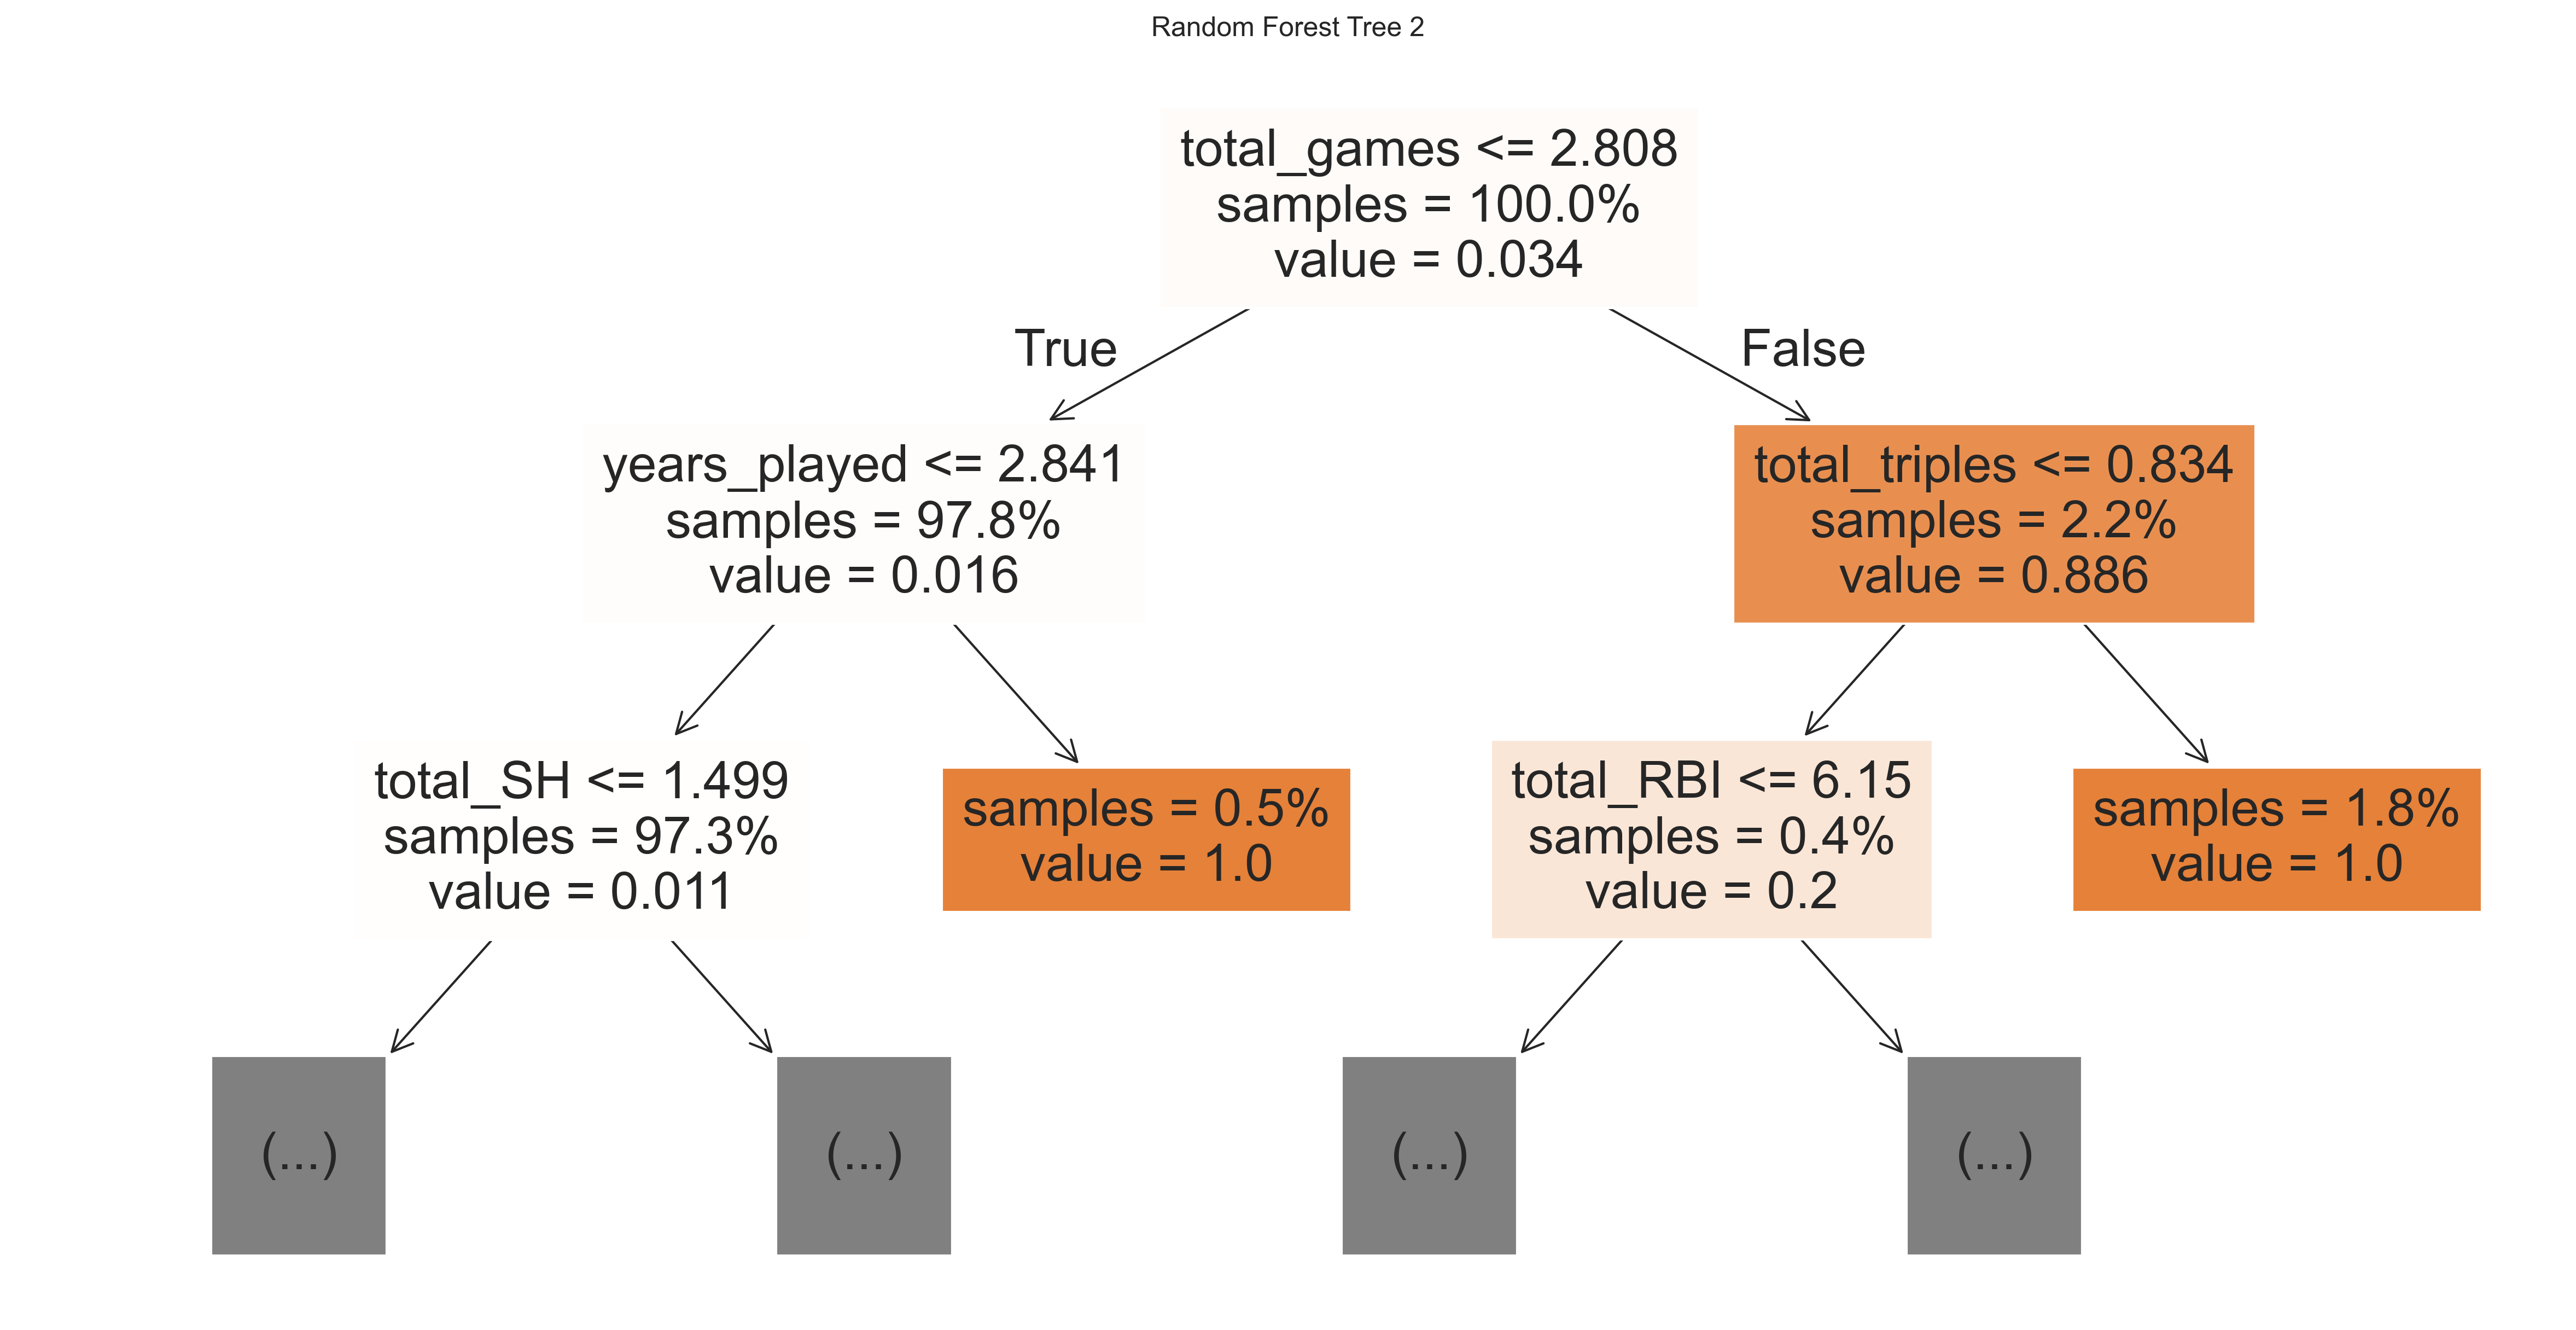

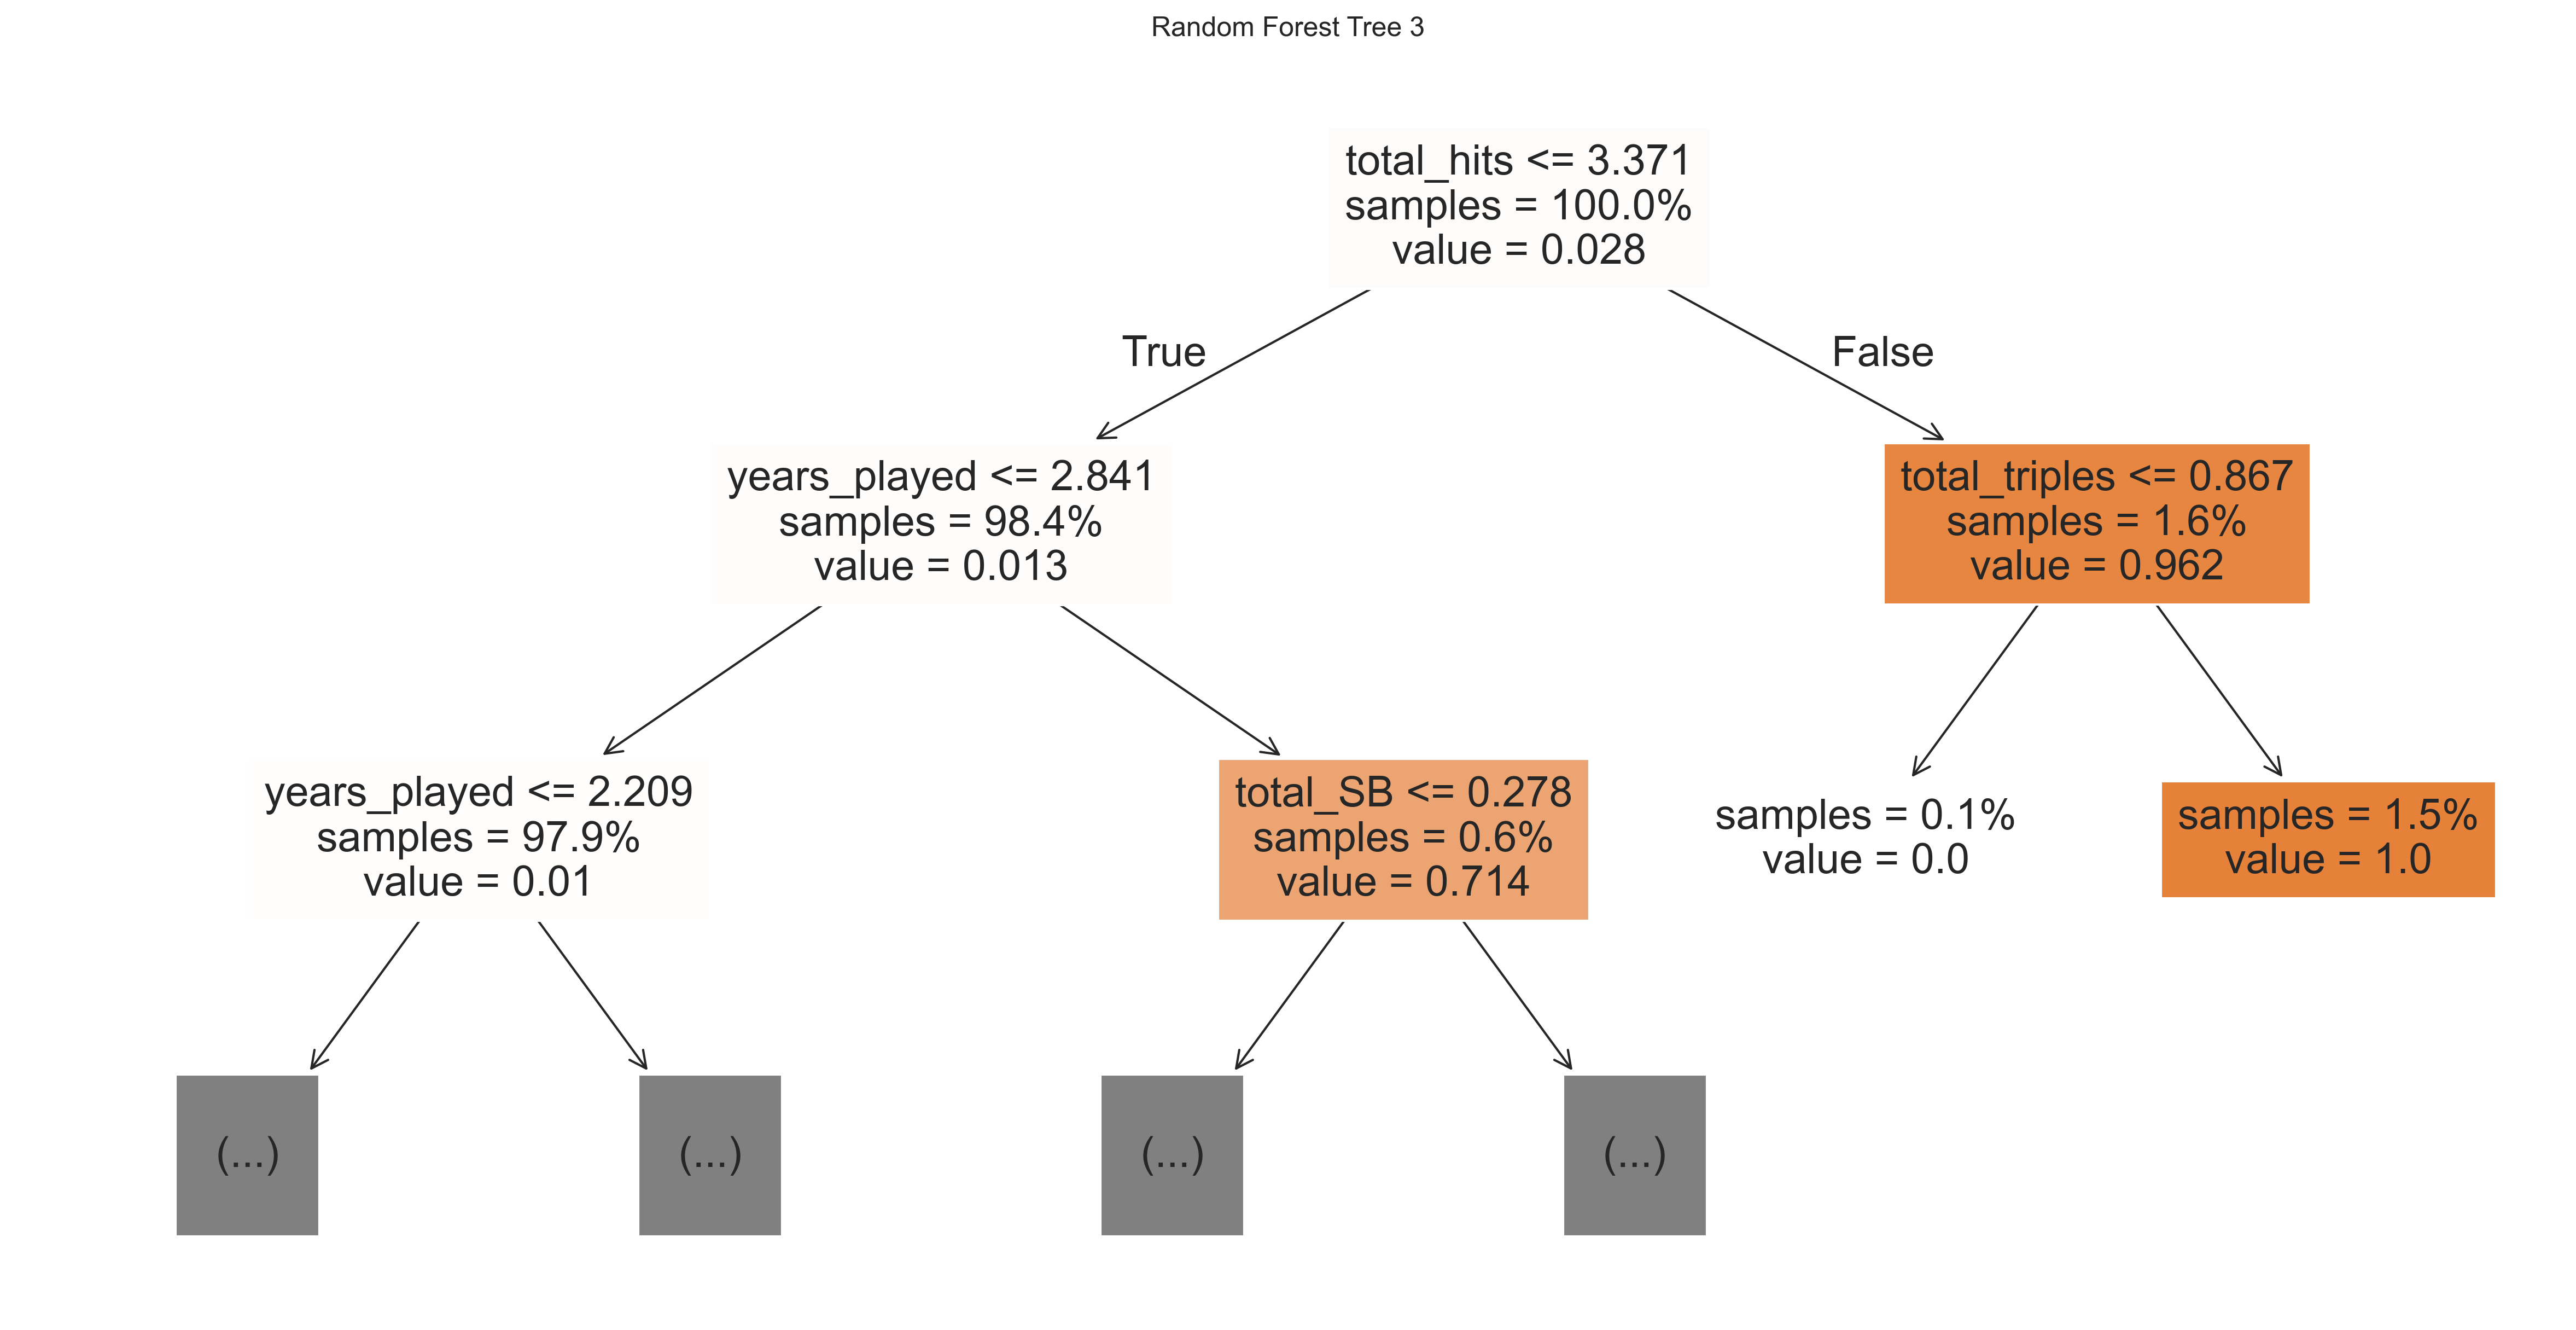

In [73]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualize individual trees
for i in range(3):  # Display first 3 trees
    tree = rfr_model_1.estimators_[i]
    plt.figure(figsize=(20, 10))
    plot_tree(
        tree, 
        feature_names=X.columns,  # Corrected keyword argument
        filled=True, 
        max_depth=2, 
        impurity=False, 
        proportion=True
    )
    plt.title(f"Random Forest Tree {i+1}")
    plt.show()


In [74]:
feature_importances = pd.Series(rfr_model_1.feature_importances_, X.columns)
top_rfr_features = feature_importances.nlargest(15)
print(top_rfr_features)

total_games      0.306476
total_at_bats    0.120203
years_played     0.106898
total_singles    0.104954
total_triples    0.040216
total_hits       0.039034
total_SH         0.029327
total_runs       0.025493
total_doubles    0.023861
total_HBP        0.019734
OPS              0.019590
OBP              0.018783
max_hits         0.017174
total_SO         0.015669
SLG              0.014618
dtype: float64


In [75]:
# Convert predictions to binary to analyze false positives and negatives
y_pred_binary = (y_pred > 0.5).astype(int)
y_test_reset = y_test.reset_index(drop=True)

# Identify false positives and false negatives
false_positives = y_test_reset[(y_test_reset == 0) & (y_pred_binary == 1)].index
false_negatives = y_test_reset[(y_test_reset == 1) & (y_pred_binary == 0)].index

# Extract player details for false positives and false negatives
false_positive_players = eng_stats_df.loc[false_positives, ['playerID'] + X]
false_negative_players = eng_stats_df.loc[false_negatives, ['playerID'] + X]

print("\nFalse Positives:")
display(false_positive_players.style.set_table_attributes("style='display:inline'"))

print("\nFalse Negatives:")
display(false_negative_players.style.set_table_attributes("style='display:inline'"))
# Feature Importance Visualization
importances = rfr_model_1.feature_importances_
feature_names = X

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()

# Player Data Comparison for False Positives
plt.figure(figsize=(12, 8))
false_positive_example = false_positive_players.melt(id_vars='playerID', value_vars=X)
sns.barplot(data=false_positive_example, x='variable', y='value')
plt.xticks(rotation=90)
plt.title("Features of False Positive Players")
plt.show()

# PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)
visual_df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'Actual': y_test_reset,
    'Predicted': y_pred_binary
})
plt.figure(figsize=(12, 8))
sns.scatterplot(data=visual_df, x='PCA1', y='PCA2', hue='Actual', style='Predicted')
plt.title("PCA of Model Predictions")
plt.show()


ValueError: Unable to coerce to Series, length must be 27: given 1